# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 22: Logarithmic Mean Risk Optimization (Kelly Criterion)

## 1. Downloading the data:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2000-01-01'
end = '2019-12-31'

start = '2016-01-01'
end = '2024-03-19'


# Tickers of assets
assets = ['AIG', 'AKAM', 'AMT', 'APA', 'BA', 'BAX', 'BKNG',
          'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'MO', 'MSFT', 'NI',
          'NKTR', 'NTAP', 'PCAR', 'PSA', 'REGN', 'SBAC', 'SEE', 'T',
          'TGT', 'TMO', 'TTWO']

assets = ['NVDA', 'SMCI', 'KNSL', 'PDD', 'CRWD', 'AVGO']

assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
# data = data.resample('M').last()

data.columns = assets

[*********************100%%**********************]  6 of 6 completed


In [5]:
# Calculating returns

#Y = data[assets].pct_change().dropna()
Y = data[assets].copy()
Y = Y.resample('M').last().pct_change().dropna()
print(Y.shape)
display(Y.head())

(57, 6)


,AVGO,CRWD,KNSL,NVDA,PDD,SMCI
Date,,,,,,
2019-07-31,0.7399%,30.4291%,-1.7709%,2.7340%,7.9496%,-5.3747%
2019-08-31,-2.5346%,-8.7459%,9.4059%,-0.6189%,47.1486%,3.2223%
2019-09-30,-1.4257%,-28.2603%,5.1715%,3.9162%,-1.6784%,1.5873%
2019-10-31,6.0782%,-14.4058%,2.3328%,15.4823%,26.8777%,7.7083%
2019-11-30,7.9768%,16.2092%,-4.1426%,7.8997%,-12.0597%,2.9981%


## 2. Estimating Logarithmic Mean Variance Portfolios

### 2.1 Calculating the portfolio that maximizes Risk Adjusted Return.

In [6]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

# port.solvers = ['MOSEK']
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

,Arithmetic,Log Approx,Log Exact
AVGO,10.8476%,18.4513%,19.1652%
CRWD,4.9972%,5.0679%,5.0954%
KNSL,16.2596%,18.1532%,18.3054%
NVDA,33.6168%,28.4162%,27.5628%
PDD,19.7782%,18.1644%,18.1009%
SMCI,14.5007%,11.7470%,11.7702%


<Axes: >

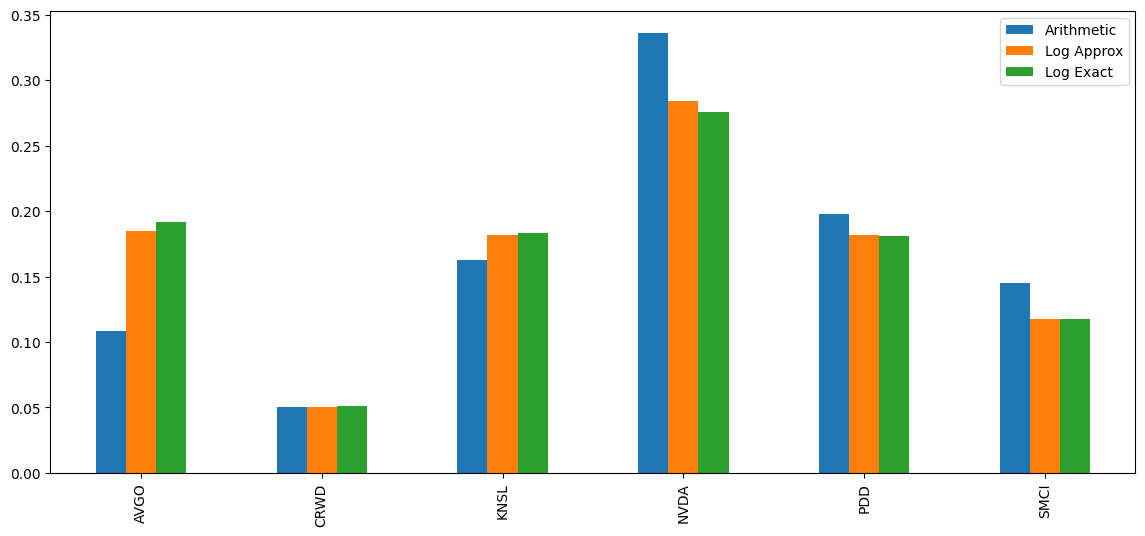

In [7]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [8]:
returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rp.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12**0.5)

Risk Adjusted Return:
Arithmetic 1.7853076080509707
Log Approx 1.7916603825068529
Log Exact 1.7917450009507414


### 2.2 Calculate efficient frontier

In [9]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, kelly="exact", points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AVGO,CRWD,KNSL,NVDA,PDD,SMCI
0,59.1388%,4.6485%,27.4456%,0.0000%,8.7671%,0.0000%
1,44.1625%,5.3004%,24.5848%,10.6881%,12.7700%,2.4942%
2,36.1478%,5.2375%,22.5858%,16.1057%,14.4826%,5.4407%
3,29.4127%,5.1838%,20.8968%,20.6529%,15.9194%,7.9344%
4,23.4006%,5.1345%,19.3812%,24.7074%,17.1996%,10.1767%


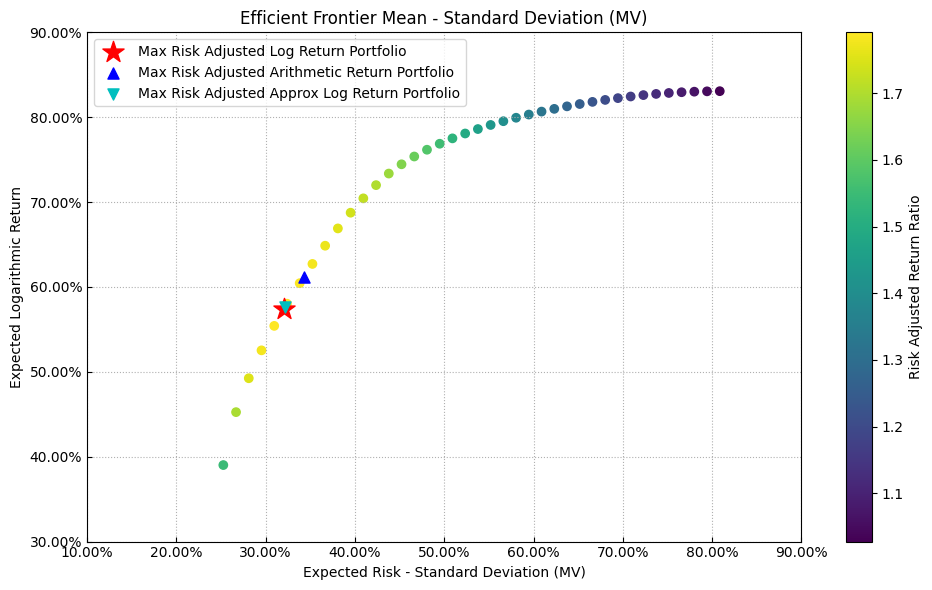

In [10]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
rp.plot_frontier(w_frontier=frontier,
                 mu=mu,
                 cov=cov,
                 returns=returns,
                 rm=rm,
                 kelly=True,
                 rf=rf,
                 alpha=0.05,
                 cmap='viridis',
                 w=w_3,
                 label=label,
                 marker='*',
                 s=16,
                 c='r',
                 height=6,
                 width=10,
                 t_factor=12,
                 ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 12 
x1 = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 12 
x2 = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()

## 2. Estimating Logarithmic Mean EVaR Portfolios

### 2.1 Calculating the portfolio that maximizes Risk Adjusted Return.

In [11]:
rm = 'EVaR' # Risk measure

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

,Arithmetic,Log Approx,Log Exact
AVGO,0.0000%,0.0004%,0.0000%
CRWD,0.0000%,3.7347%,4.3735%
KNSL,27.7626%,34.9767%,34.9131%
NVDA,0.0000%,5.6558%,5.2740%
PDD,34.6199%,32.6824%,32.9163%
SMCI,37.6175%,22.9500%,22.5231%


<Axes: >

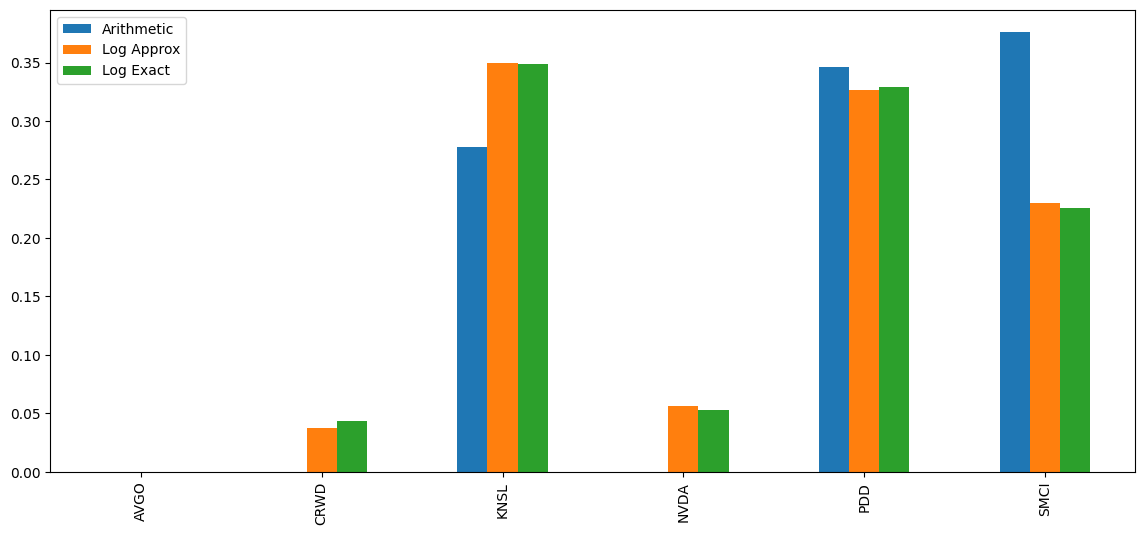

In [12]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [13]:
returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rp.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12**0.5)

Risk Adjusted Return:
Arithmetic 1.926040703799151
Log Approx 1.9526695232740399
Log Exact 1.9527866026411171


### 3.2 Calculate efficient frontier

In [14]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, kelly="exact", points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AVGO,CRWD,KNSL,NVDA,PDD,SMCI
0,14.6961%,0.0001%,35.2320%,5.4940%,34.7089%,9.8689%
1,0.0000%,10.0236%,33.6629%,1.5257%,34.9528%,19.8350%
2,0.0000%,5.6283%,34.6362%,4.4420%,33.3686%,21.9249%
3,0.0000%,3.4732%,33.7592%,4.7572%,32.8759%,25.1345%
4,0.0000%,2.6647%,31.7581%,3.4300%,33.1317%,29.0155%


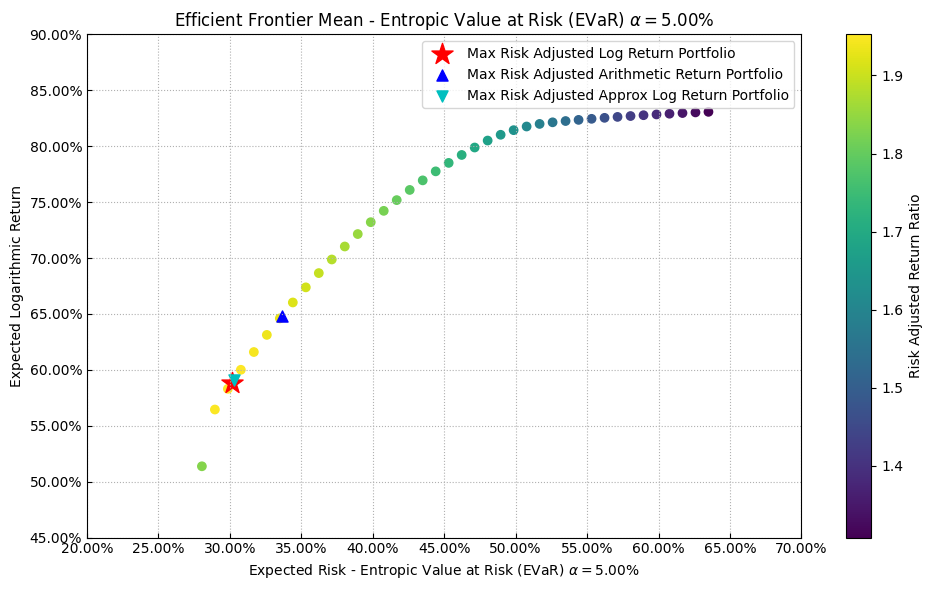

In [15]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
rp.plot_frontier(w_frontier=frontier,
                 mu=mu,
                 cov=cov,
                 returns=returns,
                 rm=rm,
                 kelly=True,
                 rf=rf,
                 alpha=0.05,
                 cmap='viridis',
                 w=w_3,
                 label=label,
                 marker='*',
                 s=16,
                 c='r',
                 height=6,
                 width=10,
                 t_factor=12,
                 ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 12
x1 = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 12
x2 = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()

## 3. Estimating Logarithmic Mean EDaR Portfolios

### 3.1 Calculating the portfolio that maximizes Risk Adjusted Return.

In [16]:
rm = 'EDaR' # Risk measure

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

,Arithmetic,Log Approx,Log Exact
AVGO,0.0000%,0.0000%,0.0000%
CRWD,18.2014%,21.6657%,21.5645%
KNSL,24.7462%,25.5426%,25.5147%
NVDA,5.6161%,5.9883%,5.9764%
PDD,21.5551%,19.4060%,19.4679%
SMCI,29.8811%,27.3975%,27.4765%


<Axes: >

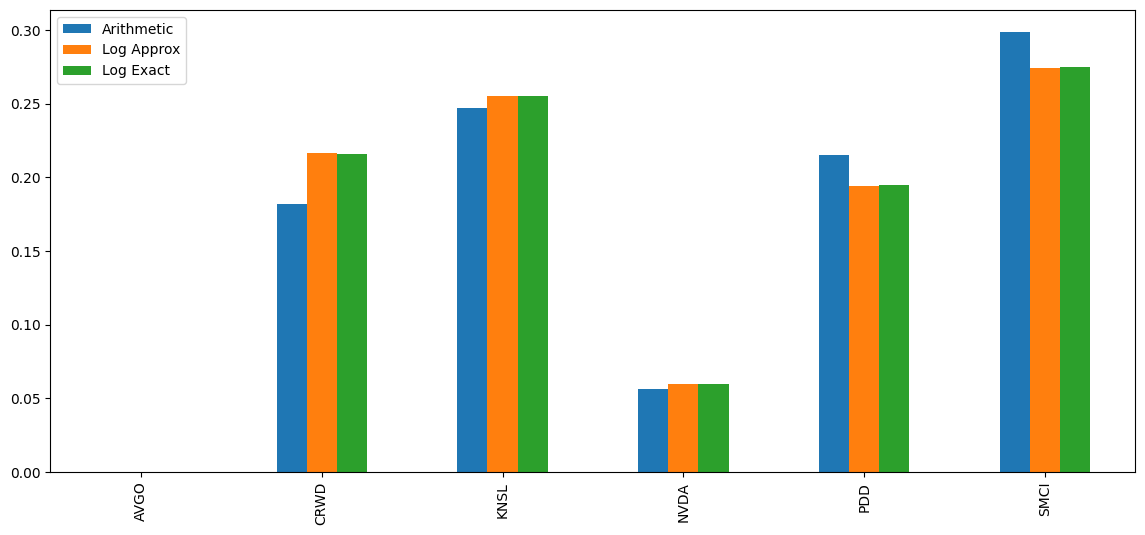

In [17]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [18]:
returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rp.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12)

Risk Adjusted Return:
Arithmetic 6.231724728677882
Log Approx 6.235957898976805
Log Exact 6.235980257516859


### 3.2 Calculate efficient frontier

In [19]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, kelly="exact", points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AVGO,CRWD,KNSL,NVDA,PDD,SMCI
0,3.5904%,21.9337%,31.8191%,2.6157%,20.1590%,19.8821%
1,0.0000%,17.7141%,24.7145%,5.9086%,21.2763%,30.3866%
2,0.0000%,13.3306%,24.4289%,8.5395%,18.7677%,34.9333%
3,0.0000%,12.0435%,22.1281%,9.1878%,18.3995%,38.2411%
4,0.0000%,12.0290%,18.9989%,9.0213%,18.9111%,41.0397%


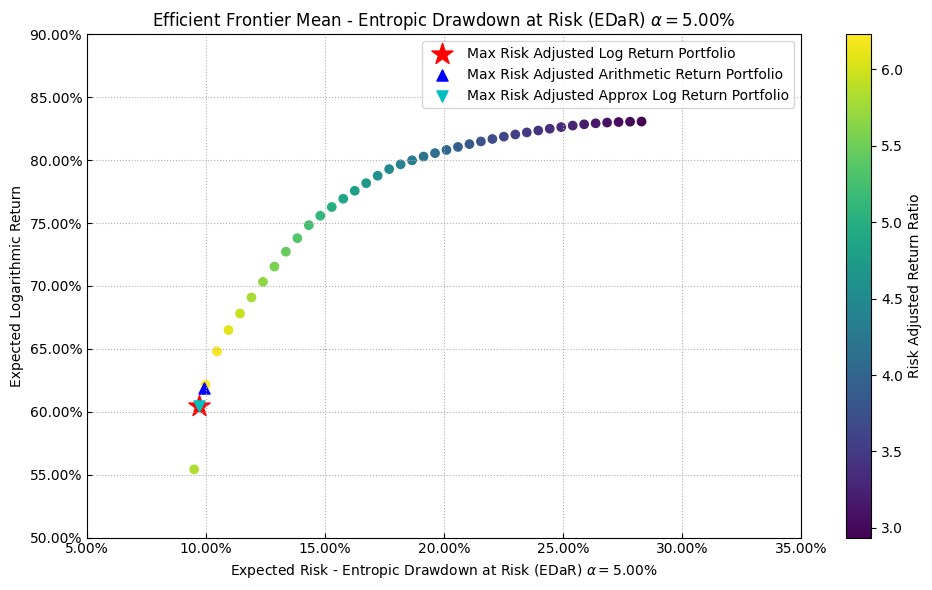

In [20]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
rp.plot_frontier(w_frontier=frontier,
                 mu=mu,
                 cov=cov,
                 returns=returns,
                 rm=rm,
                 kelly=True,
                 rf=rf,
                 alpha=0.05,
                 cmap='viridis',
                 w=w_3,
                 label=label,
                 marker='*',
                 s=16,
                 c='r',
                 height=6,
                 width=10,
                 t_factor=12,
                 ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 12
x1 = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 12
x2 = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()

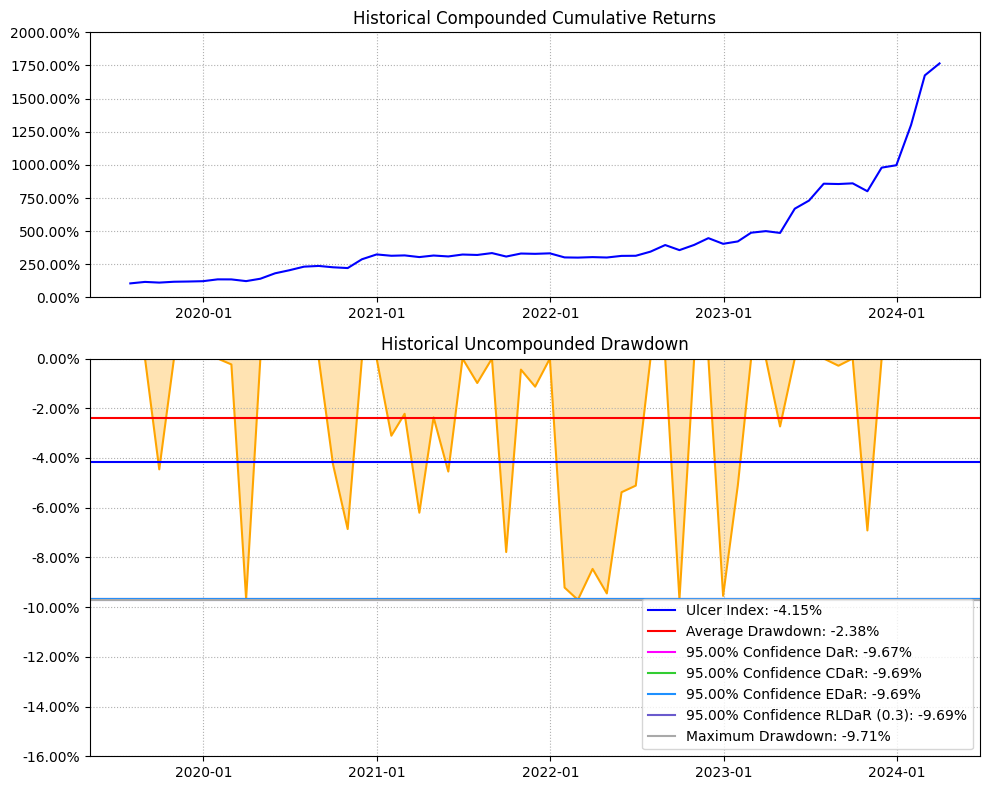

In [33]:
# Plotting the drawdown risk measures

ax = rp.plot_drawdown(returns=Y,
                      w=w_2,
                      alpha=0.05,
                      height=8,
                      width=10,
                      height_ratios=[2, 3],
                      ax=None)
